In [1]:
import sys
import torch
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("..")


In [2]:
from src.nn.util import fit, batch_generator
from src.nn.tensor.seq2seq import Tensors
from src.nn.model.seq2seq import Encoder, Seq2Seq, DecoderWithAttention


##### *Importing Weather data*

In [10]:
# 1. Read CSV file into a DataFrame
# The CSV file located at "../dh/misc/weather.csv" is read into a pandas DataFrame.
# The first column is used as the index of the DataFrame.
df = pd.read_csv("../dh/misc/weather.csv", index_col=0)

target = 'EAST'
for lag in [24,36,48,60,72]: df[f'{target}_L{lag}'] = df[target].shift(lag)
df = df[[col for col in df.columns if target in col]] 

# 2. Add a column 'EVENT' with random 0s and 1s, where 1 has a probability of 1/8
# A new column 'EVENT' is added to the DataFrame. This column consists of random 0s and 1s.
# The probability of getting a 1 is 1/8 (12.5%), and the probability of getting a 0 is 7/8 (87.5%).
df["EVENT"] = np.random.choice([0, 1], size=df.shape[0], p=[0.0, 1.0])

# 3. Drop any rows with missing values and convert DataFrame to a tensor
# All rows containing any NaN values are dropped from the DataFrame.
# The cleaned DataFrame is then converted into a PyTorch tensor with dtype float.
x = torch.tensor(df.dropna().to_numpy(), dtype=torch.float)


##### *Defining Object: Seq2Seq.Tensors*

In [12]:
input_seq_length = 144
output_seq_length = 24
target_indices = np.arange(x.shape[1] - 1).tolist()

tensors = Tensors(
    x,
    input_seq_length=input_seq_length,
    output_seq_length=output_seq_length,
    target_index=target_indices,
    time_index=-1,
    offset=0,
    train_test_val=True,
    train_size=0.5
)


#### *Initiliazing Seq2Seq Model*

In [14]:
probabilistic = True
dist_size = 2 if probabilistic else 1
enc_feature_size = tensors.enc_inputs.shape[-1]
dec_feature_size = tensors.dec_inputs.shape[-1]
dec_target_size = tensors.dec_targets.shape[-1]
lr = 0.0005
num_epochs = 300
batch_size = 32
hidden_size = 8
num_gru_layers = 1
grad_clip = 1.0
scheduled_sampling_decay = 10
dropout = 0.01


encoder = Encoder(enc_feature_size, hidden_size, num_gru_layers, dropout)
decoder_args = (
    dec_feature_size,
    dec_target_size,
    hidden_size,
    num_gru_layers,
    target_indices,
    dropout,
    dist_size,
    probabilistic
)
decoder = DecoderWithAttention(*decoder_args)
seq2seq = Seq2Seq(encoder, decoder, lr, grad_clip, probabilistic)


In [15]:
best_model = fit(seq2seq, tensors.train, tensors.validation, num_epochs, batch_size)

║ EPOCH 01	 ║ TRAIN LOSS: 9.72204	 ║ VAL LOSS: 133753.08548	 ║ TEACH: 0.91	 ║ TIME: 14.0s	 ║ (NEW BEST)
║ EPOCH 02	 ║ TRAIN LOSS: 1.23218	 ║ VAL LOSS: 3746.25125	 ║ TEACH: 0.90	 ║ TIME: 13.8s	 ║ (NEW BEST)
║ EPOCH 03	 ║ TRAIN LOSS: 0.73267	 ║ VAL LOSS: 2.12182	 ║ TEACH: 0.89	 ║ TIME: 15.3s	 ║ (NEW BEST)
║ EPOCH 04	 ║ TRAIN LOSS: 0.43082	 ║ VAL LOSS: 1.73665	 ║ TEACH: 0.88	 ║ TIME: 13.7s	 ║ (NEW BEST)
║ EPOCH 05	 ║ TRAIN LOSS: 0.18304	 ║ VAL LOSS: 2.13808	 ║ TEACH: 0.87	 ║ TIME: 13.6s	 ║
║ EPOCH 06	 ║ TRAIN LOSS: 0.01350	 ║ VAL LOSS: 2.78408	 ║ TEACH: 0.86	 ║ TIME: 14.4s	 ║
║ EPOCH 07	 ║ TRAIN LOSS: -0.12609	 ║ VAL LOSS: 3.61835	 ║ TEACH: 0.85	 ║ TIME: 16.7s	 ║
║ EPOCH 08	 ║ TRAIN LOSS: -0.25331	 ║ VAL LOSS: 4.26744	 ║ TEACH: 0.83	 ║ TIME: 16.0s	 ║
║ EPOCH 09	 ║ TRAIN LOSS: -0.32831	 ║ VAL LOSS: 4.76885	 ║ TEACH: 0.82	 ║ TIME: 18.5s	 ║
║ EPOCH 10	 ║ TRAIN LOSS: -0.37830	 ║ VAL LOSS: 4.52676	 ║ TEACH: 0.80	 ║ TIME: 14.6s	 ║
║ EPOCH 11	 ║ TRAIN LOSS: -0.41460	 ║ VAL LOSS: 4.75619	 ║ TEACH

#### *Evaluate the Seq2Seq Best-Model*

In [16]:
# Ensure the model is in evaluation mode
best_model.eval()

# Lists to hold loss values for evaluation
trained_model_losses = []

# Iterate over batches of test data
for batch_enc_inputs, batch_dec_inputs, batch_dec_targets, _ in batch_generator(tensors.test, batch_size):
    # Perform forward pass with the model to get outputs
    with torch.no_grad():  # Disable gradient computation for efficiency during evaluation
        outputs = best_model(batch_enc_inputs, batch_dec_inputs)

    # Compute loss for the current batch
    trained_model_loss = best_model.compute_loss(outputs, batch_dec_targets)
    
    # Append the computed loss to the list
    trained_model_losses.append(trained_model_loss)  # Convert tensor to float for better readability

# Calculate the mean loss over all batches
mean_test_loss = np.mean(trained_model_losses)

# Print the mean test loss
print(f"BEST-MODEL: TEST LOSS: {mean_test_loss:.5f}")


BEST-MODEL: TEST LOSS: -1.26338


#### *Visualization of Prediction*

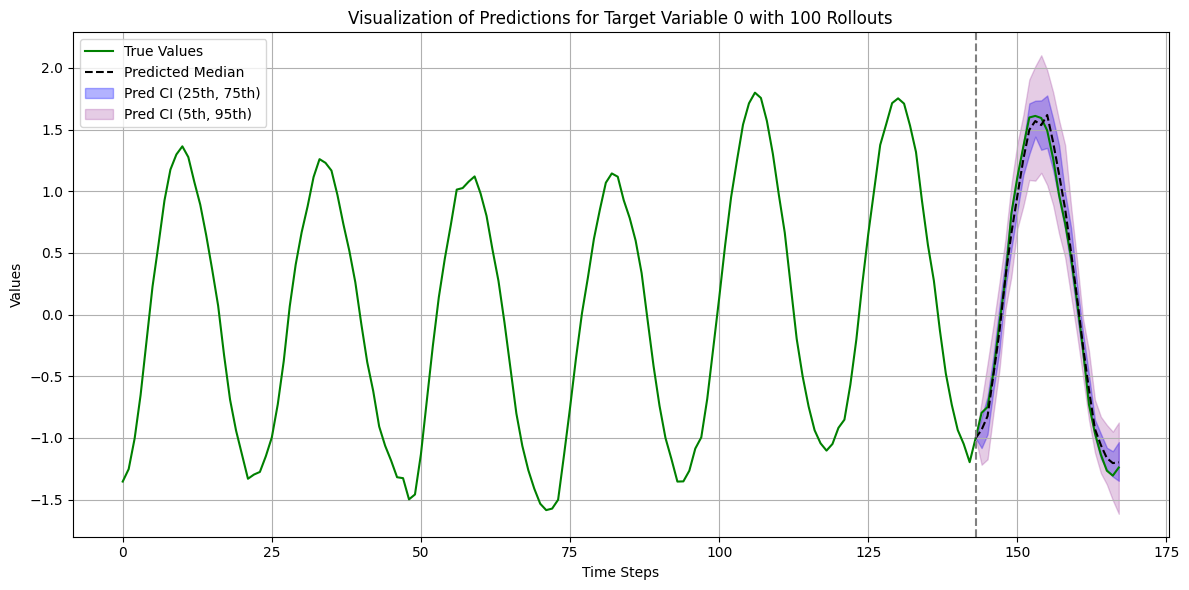

In [34]:
# Visualize
target_to_vis = 0 # number of the target variable to visualize
num_batch_to_vis = 1 # number of batches to visualize
num_rollouts = 100 # number of rollouts 

# Ensure the model is in evaluation mode
best_model.eval()

with torch.no_grad():
    # Get a batch of test samples, unscaled
    batch_enc_inputs, batch_dec_inputs, batch_dec_targets, scalers = \
        next(batch_generator(tensors.test, num_batch_to_vis, unscale=True))

    # Initialize a list to hold the model outputs for each rollout
    outputs = []
    for r in range(num_rollouts):
        # Generate predictions from the model and sample from the output distribution
        outputs.append(Seq2Seq.sample_from_output(best_model(batch_enc_inputs, batch_dec_inputs)))
    # Stack the outputs across rollouts to analyze prediction distribution
    outputs = torch.stack(outputs, dim=1)

# Iterate over each sample to visualize
for vis_to_disp in range(batch_enc_inputs.shape[0]):
    # Extract and flatten the relevant target variable's data for visualization
    sample_enc_inputs = batch_enc_inputs[vis_to_disp, :, target_to_vis].flatten().tolist()
    sample_dec_inputs = batch_dec_inputs[vis_to_disp, :, target_to_vis].flatten().tolist()
    sample_dec_targets = batch_dec_targets[vis_to_disp, :, target_to_vis].flatten().tolist()

    # Create a figure for the current sample
    plt.figure(figsize=(12, 6))
    x = list(range(len(sample_enc_inputs) + len(sample_dec_targets)))
    
    # Plot the true values (encoder inputs followed by decoder targets)
    plt.plot(x, sample_enc_inputs + sample_dec_targets, label="True Values", linestyle='-', color='green')
    
    # Plot the median of the model's predictions
    output_x = list(range(len(sample_enc_inputs)-1, len(x)))
    plt.plot(output_x, np.hstack([sample_enc_inputs[-1], np.median(outputs[vis_to_disp, :, :, target_to_vis], axis=0)]), c="k", label="Predicted Median", linestyle='--')
    
    # Plot the 25th and 75th percentiles as a shaded confidence interval
    plt.fill_between(
        output_x,
        np.hstack([sample_enc_inputs[-1], np.quantile(outputs[vis_to_disp, :, :, target_to_vis], 0.25, axis=0)]),
        np.hstack([sample_enc_inputs[-1], np.quantile(outputs[vis_to_disp, :, :, target_to_vis], 0.75, axis=0)]),
        alpha=0.3,
        interpolate=True,
        color="blue",
        label="Pred CI (25th, 75th)"
    )

    # Plot the 5th and 95th percentiles as a wider shaded confidence interval
    plt.fill_between(
        output_x,
        np.hstack([sample_enc_inputs[-1], np.quantile(outputs[vis_to_disp, :, :, target_to_vis], 0.05, axis=0)]),
        np.hstack([sample_enc_inputs[-1], np.quantile(outputs[vis_to_disp, :, :, target_to_vis], 0.95, axis=0)]),
        alpha=0.2,
        interpolate=True,
        color="purple",
        label="Pred CI (5th, 95th)"
    )

    # Add grid and legend to the plot
    plt.grid(True)
    plt.legend()

    # Add title and axis labels
    plt.title(f"Visualization of Predictions for Target Variable {target_to_vis} with {num_rollouts} Rollouts" if probabilistic else f"Visualization of Predictions for Target Variable {target_to_disp}")
    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    
    # Annotate the transition point from encoder inputs to decoder targets
    plt.axvline(x=len(sample_enc_inputs)-1, color='gray', linestyle='--', label='Transition Point')
    
    # Show the plot
    plt.tight_layout()
    plt.show()
